In [4]:

import pandas as pd
import numpy as np
import statsmodels.api as sm
import pandas_market_calendars as mcal

# Load and prepare data
df = pd.read_csv("../output/all_vols.csv", parse_dates=['date'])
df['date'] = pd.to_datetime(df['date']).dt.normalize()  # remove time if present, ensures date-only
#df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None)

df.sort_values(['ticker', 'date'], inplace=True)


# Ensure global NYSE date alignment
nyse = mcal.get_calendar('NYSE')
global_dates = nyse.valid_days(start_date=df['date'].min(), end_date=df['date'].max()).tz_convert(None).normalize()
#tickers = df['ticker'].unique()
#full_index = pd.MultiIndex.from_product([global_dates, tickers], names=['date', 'ticker'])

# Pivot data into a matrix (dates x tickers)
vol_matrix = df.pivot(index='date', columns='ticker', values='annualized_vol_30min').reindex(global_dates)

# HAR features as rolling windows
har_1d = vol_matrix.shift(1)
har_1w = har_1d.rolling(window=5, min_periods=5).mean()
har_1m = har_1d.rolling(window=21, min_periods=21).mean()

# Cross-sectional regression results container
results = []

<Axes: title={'center': 'HAR Cross-Sectional Coefficients'}, xlabel='date'>

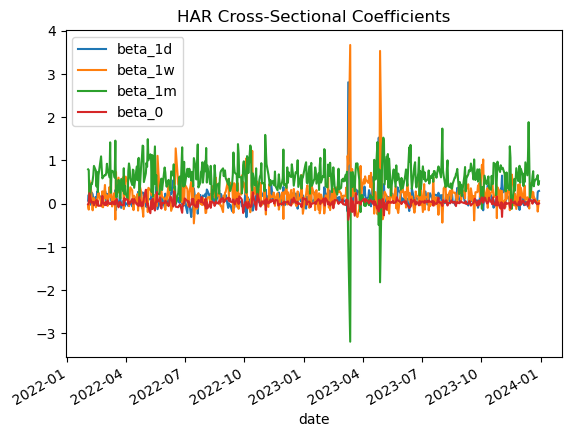

In [5]:

# Run efficient numerical cross-sectional regressions
for date in global_dates:
    y = vol_matrix.loc[date].values
    X = np.vstack([
        np.ones_like(y),
        har_1d.loc[date].values,
        har_1w.loc[date].values,
        har_1m.loc[date].values
    ]).T

    # Drop rows with NaNs
    valid = ~np.isnan(X).any(axis=1) & ~np.isnan(y)
    if valid.sum() < 10:
        continue

    beta, residuals, _, _ = np.linalg.lstsq(X[valid], y[valid], rcond=None)

    results.append({
        'date': date,
        'beta_0': beta[0],
        'beta_1d': beta[1],
        'beta_1w': beta[2],
        'beta_1m': beta[3],
        'rmse': np.sqrt(np.mean((y[valid] - X[valid] @ beta)**2)),
        'n_obs': valid.sum()
    })

# Results DataFrame
cs_har_results = pd.DataFrame(results)

# Quick visualization
cs_har_results.set_index('date')[['beta_1d', 'beta_1w', 'beta_1m', 'beta_0']].plot(title="HAR Cross-Sectional Coefficients")


In [6]:
df["date"]
vol_matrix

ticker,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
2022-01-03,0.269868,0.930370,0.415674,0.211718,0.307676,0.239183,0.248137,0.351878,0.279657,0.398943,...,0.634914,0.385349,0.182516,0.201060,0.535662,0.383829,0.336552,0.497289,0.354164,0.333206
2022-01-04,0.398911,0.374645,0.322541,0.346671,0.284898,0.469979,0.423939,0.244138,0.472584,0.704541,...,0.361207,0.449303,0.319315,0.346167,0.269808,0.251979,0.701345,0.629856,0.336778,0.509081
2022-01-05,0.388910,0.628846,0.667765,0.346059,0.363478,0.459037,0.295750,0.254450,0.460165,0.324238,...,0.632626,0.314231,0.350128,0.426792,0.441527,0.306539,0.583124,0.413905,0.404783,0.419095
2022-01-06,0.417536,0.367453,0.379018,0.196991,0.223988,0.424555,0.250434,0.227992,0.341718,0.569086,...,0.445304,0.356714,0.308257,0.370028,0.403791,0.356763,0.390913,0.499982,0.509289,0.689043
2022-01-07,0.459672,0.780101,0.493696,0.435800,0.297110,0.358788,0.180158,0.169684,0.311894,0.763446,...,0.389827,0.325955,0.184277,0.221578,0.298654,0.190865,0.333464,0.486177,0.446991,0.421434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,0.326101,0.335944,0.312881,0.227454,0.158727,NaN,0.197510,0.352209,0.252148,0.261574,...,0.258282,0.188738,0.276574,0.251983,0.226206,0.209567,0.281458,0.490759,0.502462,0.308202
2023-12-26,0.203560,0.268674,0.360622,0.131526,0.117646,NaN,0.158580,0.157994,0.166714,0.148435,...,0.217970,0.162954,0.193542,0.120278,0.065840,0.165948,0.173011,0.230501,0.210968,0.152293
2023-12-27,0.231894,0.295385,0.379301,0.205389,0.169536,NaN,0.097395,0.113040,0.164193,0.111430,...,0.232879,0.132110,0.139911,0.182209,0.134995,0.126569,0.152095,0.275925,0.319657,0.129128
2023-12-28,0.143037,0.264420,0.282377,0.093192,0.088847,NaN,0.080776,0.184529,0.145452,0.183239,...,0.303087,0.146394,0.185887,0.120233,0.105716,0.117764,0.102490,0.184074,0.160921,0.226902


In [7]:
cs_har_results

,date,beta_0,beta_1d,beta_1w,beta_1m,rmse,n_obs
0,2022-02-02,-0.012546,0.069941,-0.048756,0.794660,0.134979,494
1,2022-02-03,0.018642,0.206684,-0.136713,0.778074,0.144292,494
2,2022-02-04,0.241267,-0.033805,0.539113,0.038317,0.148400,494
3,2022-02-07,0.022528,0.000123,0.268666,0.472532,0.101108,494
4,2022-02-08,0.047471,0.250520,0.035208,0.457869,0.112032,494
...,...,...,...,...,...,...,...
475,2023-12-22,0.087825,0.055994,0.126877,0.512922,0.113788,495
476,2023-12-26,-0.010374,-0.002906,0.030674,0.601861,0.054254,495
477,2023-12-27,0.001537,0.267177,-0.182317,0.661128,0.076354,495
478,2023-12-28,-0.009470,0.289433,-0.033472,0.433616,0.061678,495


In [8]:
cs_har_result_av=cs_har_results.set_index('date')[["beta_0","beta_1d","beta_1w","beta_1m"]].rolling(window=5, min_periods=5).mean()

<Axes: title={'center': 'HAR Cross-Sectional Coefficients'}, xlabel='date'>

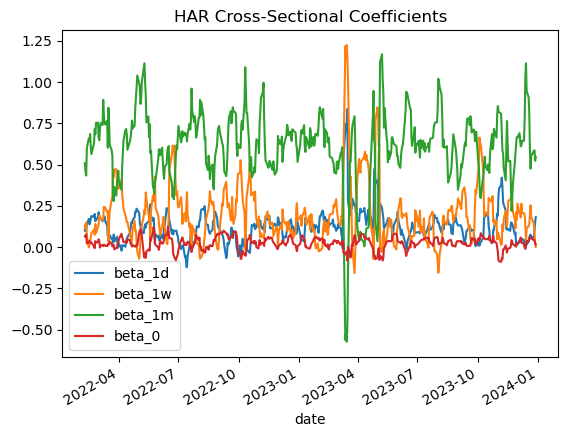

In [9]:
cs_har_result_av[['beta_1d', 'beta_1w', 'beta_1m', 'beta_0']].plot(title="HAR Cross-Sectional Coefficients")

In [10]:
# Add forecast using rolling average betas
forecast_df = vol_matrix.copy()

# Compute rolling betas (aligned with vol_matrix dates)
rolling_betas = cs_har_result_av.reindex(vol_matrix.index)

# Calculate forecasted volatility explicitly
forecast_df = (
    rolling_betas["beta_0"].values[:, None] +
    rolling_betas["beta_1d"].values[:, None] * har_1d.values +
    rolling_betas["beta_1w"].values[:, None] * har_1w.values +
    rolling_betas["beta_1m"].values[:, None] * har_1m.values
)

# Actual volatility
actual_vol = vol_matrix.values

# Compute out-of-sample RMSE (ignoring NaNs)
rmse = np.sqrt(np.nanmean((forecast_df - actual_vol)**2,axis=1))
rmse
#print(f"Out-of-sample RMSE: {rmse:.4f}")

/var/folders/c1/dv7w7b2x49j3spqsxnz6y_sw0000gn/T/ipykernel_92254/421113791.py:19: RuntimeWarning: Mean of empty slice
  rmse = np.sqrt(np.nanmean((forecast_df - actual_vol)**2,axis=1))


array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
       0.11549782, 0.14046327, 0.14538087, 0.18119946, 0.11891494,
       0.14101382, 0.1236003 , 0.1405287 , 0.13548614, 0.181205  ,
       0.14805597, 0.21387678, 0.16506256, 0.36400109, 0.17299825,
       0.17913004, 0.1224921 , 0.14427091, 0.21052301, 0.44212642,
       0.2324642 , 0.23004979, 0.22264717, 0.16420366, 0.11540885,
       0.27996918, 0.19012133, 0.18371898, 0.13360798, 0.15846329,
       0.11683091, 0.09903415, 0.13189033, 0.1051991 , 0.12742046,
       0.11050935, 0.1241623 , 0.16730617, 0.12375754, 0.11942202,
       0.13291987, 0.11955604, 0.14026375, 0.11412294, 0.10401628,
       0.14216009, 0.10827176, 0.11046432, 0.11462648, 0.15497

In [19]:
import pandas as pd
import pandas_market_calendars as mcal

# Load earnings file
earnings_df = pd.read_csv("../data/earnings_calendar.csv")
earnings_df = earnings_df.dropna(subset=['act_symbol'])
earnings_df['date'] = pd.to_datetime(earnings_df['date']).dt.normalize() 
earnings_dict={}
# Set up NYSE calendar
nyse = mcal.get_calendar('NYSE')
min_date, max_date = earnings_df['date'].min(), earnings_df['date'].max()
trading_days = nyse.valid_days(start_date=min_date, end_date=max_date)

# Generate exclusion set: (ticker, excluded_date) for ±1 trading day
excluded_dates = []
#global_dates = nyse.valid_days(start_date=df['date'].min(), end_date=df['date'].max()).tz_convert(None).normalize()
for _, row in earnings_df.iterrows():
    symbol = row['act_symbol']
    if symbol not in earnings_dict.keys():
        earnings_dict[symbol] = []
    date = row['date']
    #print(f"Processing earnings for {symbol} on {date}")
    #if 'AAPL' in earnings_dict.keys():
    #    print(f"symbol: {symbol} apple earning dates: {earnings_dict[symbol]}")
    if date in global_dates:
        
        idx = global_dates.get_loc(date)
        #print(f"Processing earnings for {symbol} on {date}, index {idx} in global_dates")
        for offset in [-1, 0, 1]:
            #if symbol == 'AAPL':
            #    print(f"symbol: {symbol}, date: {date}, idx: {idx}, offset: {offset}")
            if 0 <= idx + offset < len(global_dates):
                if symbol == 'AAPL':
                    print(f"symbol: {symbol}, date: {date}, idx: {idx}, offset: {offset}")
                earnings_dict[symbol].append(global_dates[idx + offset].date())
                excluded_dates.append((symbol, global_dates[idx + offset].date()))
                if symbol == 'AAPL':
                    print(f"Added excluded date for {symbol}: {earnings_dict[symbol]}")

#for symbol, dates in earnings_dict.items():
#    earnings_dict[symbol] = set(dates)  # Convert to set for fast lookup

# Convert to set for fast lookup
excluded_mask_set = set(excluded_dates)
# Create mask matrix where True = include, False = exclude
mask_matrix = np.ones_like(vol_matrix, dtype=bool)

for (ticker, date) in excluded_mask_set:
    if ticker in vol_matrix.columns and pd.Timestamp(date) in vol_matrix.index:
        mask_matrix[vol_matrix.index.get_loc(pd.Timestamp(date)), vol_matrix.columns.get_loc(ticker)] = False

symbol: AAPL, date: 2022-04-28 00:00:00, idx: 80, offset: -1
Added excluded date for AAPL: [datetime.date(2022, 4, 27)]
symbol: AAPL, date: 2022-04-28 00:00:00, idx: 80, offset: 0
Added excluded date for AAPL: [datetime.date(2022, 4, 27), datetime.date(2022, 4, 28)]
symbol: AAPL, date: 2022-04-28 00:00:00, idx: 80, offset: 1
Added excluded date for AAPL: [datetime.date(2022, 4, 27), datetime.date(2022, 4, 28), datetime.date(2022, 4, 29)]
symbol: AAPL, date: 2022-07-28 00:00:00, idx: 142, offset: -1
Added excluded date for AAPL: [datetime.date(2022, 4, 27), datetime.date(2022, 4, 28), datetime.date(2022, 4, 29), datetime.date(2022, 7, 27)]
symbol: AAPL, date: 2022-07-28 00:00:00, idx: 142, offset: 0
Added excluded date for AAPL: [datetime.date(2022, 4, 27), datetime.date(2022, 4, 28), datetime.date(2022, 4, 29), datetime.date(2022, 7, 27), datetime.date(2022, 7, 28)]
symbol: AAPL, date: 2022-07-28 00:00:00, idx: 142, offset: 1
Added excluded date for AAPL: [datetime.date(2022, 4, 27), d

In [17]:

vol_matrix.index

DatetimeIndex(['2022-01-03', '2022-01-04', '2022-01-05', '2022-01-06',
               '2022-01-07', '2022-01-10', '2022-01-11', '2022-01-12',
               '2022-01-13', '2022-01-14',
               ...
               '2023-12-15', '2023-12-18', '2023-12-19', '2023-12-20',
               '2023-12-21', '2023-12-22', '2023-12-26', '2023-12-27',
               '2023-12-28', '2023-12-29'],
              dtype='datetime64[ns]', length=501, freq=None)

Text(0, 0.5, 'Date')

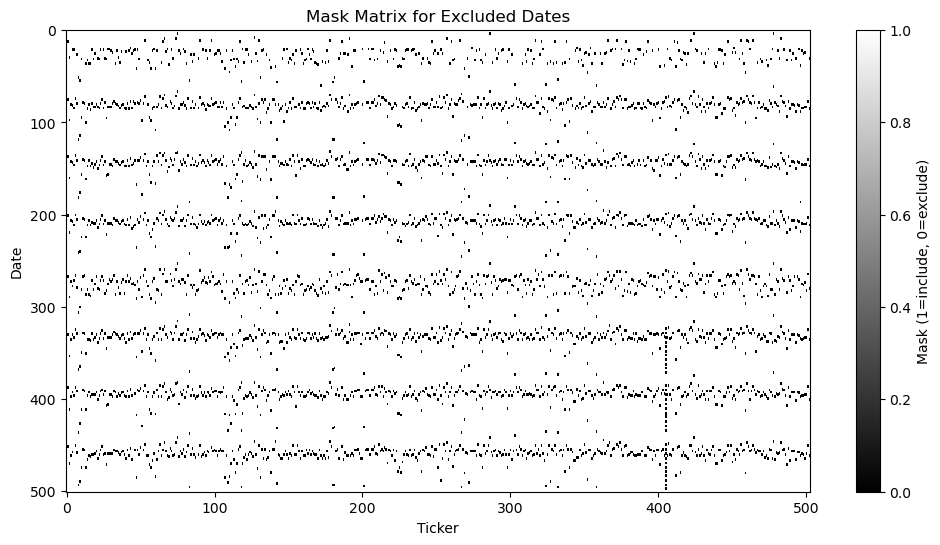

In [20]:
import matplotlib.pyplot as plt
mask_matrix
#visualize the matrix
plt.figure(figsize=(12, 6))
plt.imshow(mask_matrix, aspect='auto', cmap='gray', interpolation='nearest')
plt.colorbar(label='Mask (1=include, 0=exclude)')
plt.title('Mask Matrix for Excluded Dates')
plt.xlabel('Ticker')
plt.ylabel('Date')  